Partie modélisation du projet

I- Après avoir regardé la corrélation entre le nombre de ligne passant par une station (noeud) et la fréquentation, nous souhaitions regarder si nous trouvions des anomalies : des stations anormalement trop fréquentées ou trop peu fréquentées par rapport au nombre de lignes.
On va construire un modèle simple qui estime la fréquentation attendue en fonction du nombre de lignes, puis on mesure l'écart.
Nous allons modéliser : Validation ≃ a . (lignes i)^b
→ Une régression log-log permet d’estimer la relation puissance.
log(NB_VALD)=α+βlog(nb_lignes_fer)
→ Puis on calcule l’erreur résiduelle → c’est là que les anomalies apparaissent.


🚨 Stations SUR-fréquentées pour leur nombre de lignes
                    station_name  nb_lignes_fer  NB_VALD  ecart_ratio
725                   Les Halles              1  49564.0    17.934354
522      Esplanade de la Défense              1  33492.0    12.118824
711       Haussmann Saint-Lazare              1  28676.0    10.376191
555                    Vincennes              1  26353.0     9.535631
1    Noisy-le-Grand - Mont d'Est              1  25244.0     9.134348
287       Marne-la-Vallée Chessy              1  23686.0     8.570598
26                         Auber              1  23377.0     8.458788
518                Château Rouge              1  22825.0     8.259051
646        Bobigny Pablo Picasso              1  22128.0     8.006847
374              Rueil-Malmaison              1  21526.0     7.789018

🧊 Stations SOUS-fréquentées pour leur nombre de lignes
                 station_name  nb_lignes_fer  NB_VALD  ecart_ratio
53           Dourdan la Forêt              1     10.

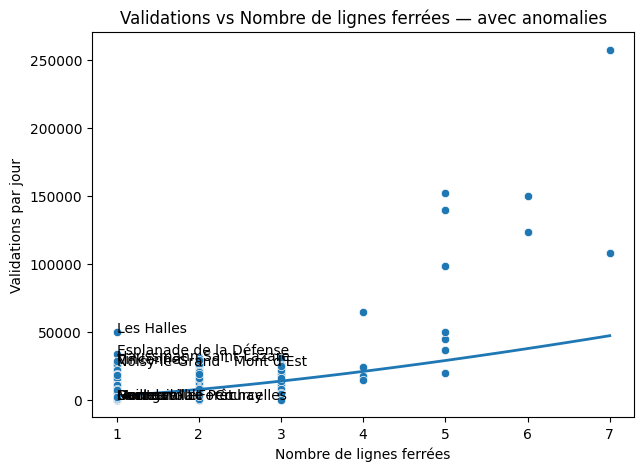

In [1]:
#Code proposé 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. Charger données finales
# -------------------------
df = pd.read_csv("data/validations/stations_vald_lignes_rf.csv")

# Filtrer valeurs incohérentes (0 ligne ou 0 validations)
df = df[(df["nb_lignes_fer"] > 0) & (df["NB_VALD"] > 0)]

# -------------------------
# 2. Regression log-log
# -------------------------
df["log_vald"] = np.log(df["NB_VALD"])
df["log_lignes"] = np.log(df["nb_lignes_fer"])

coeffs = np.polyfit(df["log_lignes"], df["log_vald"], 1)
beta = coeffs[0]    # élasticité
alpha = coeffs[1]   # intercept

df["vald_pred"] = np.exp(alpha + beta * df["log_lignes"])
df["ecart_ratio"] = df["NB_VALD"] / df["vald_pred"]

# -------------------------
# 3. Identifier anomalies
# -------------------------
HIGH = df.sort_values("ecart_ratio", ascending=False).head(10)
LOW  = df.sort_values("ecart_ratio", ascending=True).head(10)

print("\n🚨 Stations SUR-fréquentées pour leur nombre de lignes")
print(HIGH[["station_name", "nb_lignes_fer", "NB_VALD", "ecart_ratio"]])

print("\n🧊 Stations SOUS-fréquentées pour leur nombre de lignes")
print(LOW[["station_name", "nb_lignes_fer", "NB_VALD", "ecart_ratio"]])

# -------------------------
# 4. Scatter plot visualisation
# -------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="nb_lignes_fer", y="NB_VALD")

# courbe prédite
l = np.linspace(1, df["nb_lignes_fer"].max(), 100)
plt.plot(l, np.exp(alpha + beta*np.log(l)), linewidth=2)

# noms des outliers
for _, row in HIGH.head(5).iterrows():
    plt.text(row.nb_lignes_fer, row.NB_VALD, row.station_name)

for _, row in LOW.head(5).iterrows():
    plt.text(row.nb_lignes_fer, row.NB_VALD, row.station_name)

plt.title("Validations vs Nombre de lignes ferrées — avec anomalies")
plt.xlabel("Nombre de lignes ferrées")
plt.ylabel("Validations par jour")
plt.show()
